# Données

In [1]:
import os
import requests
from scipy.io import loadmat
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def get_mnist(): 
    mnist = fetch_openml('mnist_784')
    X = mnist['data'].values
    X = (mnist['data'] > 128).astype(int)
    y = mnist['target'].values
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

    return X, y
    
def get_alphadigs():
    if os.path.exists('data/alphadigs.mat'):
        return loadmat('data/alphadigs.mat')
    
    alphadigs_url = 'https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat'
    r = requests.get(alphadigs_url, allow_redirects=True)

    with open('data/alphadigs.mat', 'wb') as f:
        f.write(r.content)
                
    return loadmat('data/alphadigs.mat')
      
def lire_alpha_digit(list_digits):
    arr = []
    dataset = get_alphadigs()
    indices = np.where(np.isin(dataset["classlabels"], list_digits))[1]
    dataset_flatten = dataset["dat"][indices].flatten()
    for img in dataset_flatten:
        arr.append(img.flatten())
    
    return np.array(arr)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
f = lire_alpha_digit(['0', '2', 'P','F', 'Z'])

In [286]:
f.shape

(195, 320)

In [3]:
import numpy as np
import numpy as np
import random
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonctions élémentaires

## Construction d’un RBM et test sur Binary AlphaDigits

In [11]:
class RBM:
    def __init__(self, p, q):
        self.W = 0.01 * np.random.rand(p,q)
        self.a = np.zeros((1,p))
        self.b = np.zeros((1,q))
        
def init_RBM(p, q):
    return RBM(p, q)

def entree_sortie_RBM(rbm, x):
    return sigmoid(np.dot(x, rbm.W) + rbm.b)

def sortie_entree_RBM(rbm, y): #(n * q) -> (n * p)
    return sigmoid(np.dot(y, rbm.W.T) + rbm.a)

In [22]:
def train_RBM(rbm,X,epsilon, epochs, batch_size):
        
    n = X.shape[0]
    p = X.shape[1]
    q = len(rbm.b) 
    
    for epoch in range(epochs):
        X_copy = X.copy()
        
        for batch  in range(0, n, batch_size):
            X_batch = X_copy[batch:batch + batch_size]
            
            tb = len(X_batch)
            
            v_0 = X_batch # (tb * p)
            #print(tb,p,v_0.shape)
            
            p_h_v_0 = entree_sortie_RBM(rbm,v_0) # (tb * q)
            #print(tb,q,p_h_v_0.shape)
            
            h_0 = (p_h_v_0 > np.random.rand(tb, q)).astype(int) # (tb * q)
            #print(tb,q,h_0.shape)
            
            p_v_h_0 = sortie_entree_RBM(rbm,h_0) # (tb * p)
            #print(tb,p,p_v_h_0.shape)
            v_1 = (p_v_h_0 > np.random.rand(tb, p)).astype(int) # (tb * p)
            #print(tb,p,v_1.shape)
            
            p_h_v_1 = entree_sortie_RBM(rbm,v_1) # (tb * q)
            #print(tb,q,p_h_v_1.shape)
            
            norm_epsilon = epsilon / tb
            
            rbm.W += norm_epsilon * np.dot(v_0.T, p_h_v_0) - np.dot(v_1.T, p_h_v_1) # (p * q)   
            #print(p,q,rbm.W.shape)     
            rbm.a += norm_epsilon * np.sum(v_0 - v_1, axis=0) # (1 * p)
            #print(p,rbm.a.shape)
            rbm.b += norm_epsilon * np.sum(p_h_v_0 - p_h_v_1, axis=0) # (1 * q)
            #print(q,rbm.b.shape)
            
    return rbm


In [ ]:
def generer_image_RBM(rbm, nb_iter, nb_images):
    p = rbm.a.shape[1]
    q = len(rbm.b)
    for i in range(nb_images):
        # Initialisation de l'image générée
        image = np.zeros(p)
        # Échantillonnage de Gibbs
        for j in range(nb_iter):
            # Propagation ascendante
            prob_h_given_v = entree_sortie_RBM(rbm, image)
            h = (prob_h_given_v > np.random.rand(q)).astype(int)
            # Propagation descendante
            prob_v_given_h = sortie_entree_RBM(rbm, h)
            image = (prob_v_given_h > np.random.rand(p)).astype(int)

        image = np.reshape(image, (20, 16))
        plt.imshow(image, cmap='gray')
        plt.show()


In [49]:
X = lire_alpha_digit(['0', '2', 'P','F', 'Z'])
p = len(X[0])
q = 100
Rbm = init_RBM(p,q)
Rbm = train_RBM(Rbm,X,0.1, 10000, 100)

/var/folders/2m/nlw4h6h974767p9gyt3k742h0000gn/T/ipykernel_877/1591538201.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


/var/folders/2m/nlw4h6h974767p9gyt3k742h0000gn/T/ipykernel_877/1591538201.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


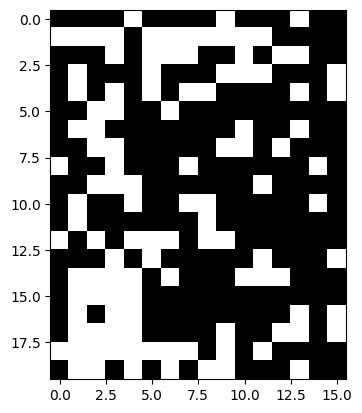

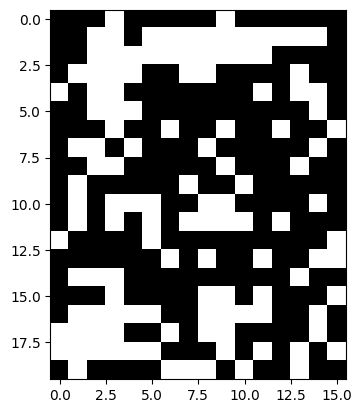

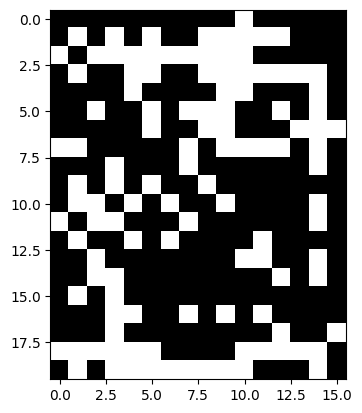

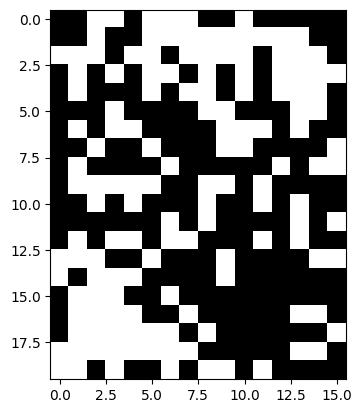

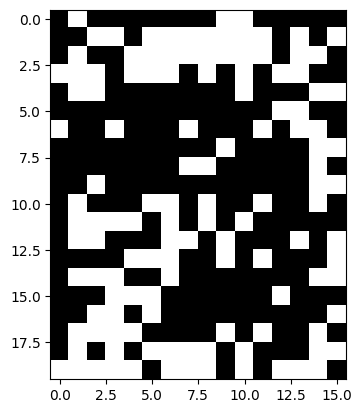

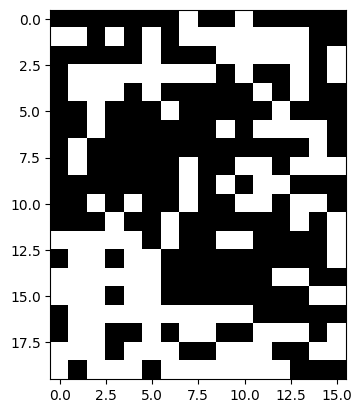

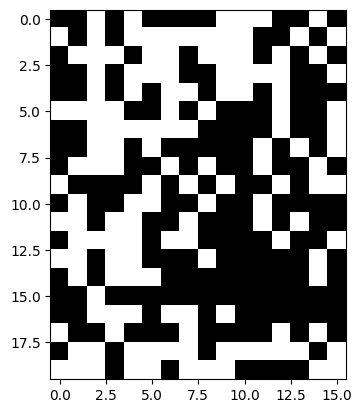

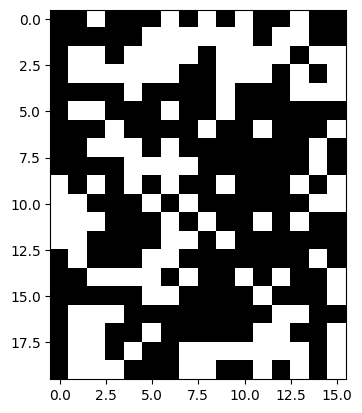

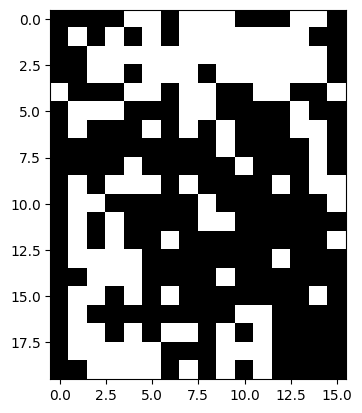

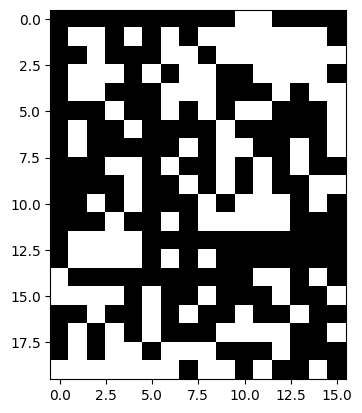

In [50]:
generer_image_RBM(Rbm, 1000, 10)